In [3]:
import pandas as pd
import numpy as np
import chardet  

def clean_csv(csv_filepath, output_filepath=None):
    # Encoding Detection
    try:
        with open(csv_filepath, 'rb') as f:
            result = chardet.detect(f.read())
        encoding = result['encoding']
        confidence = result['confidence']
        print(f"Detected encoding: {encoding} with confidence: {confidence}")
        if confidence < 0.8:
            print("Warning: Low encoding detection confidence. Defaulting to 'Windows-1252'.")
            encoding = 'Windows-1252'  # Default fallback encoding
    except FileNotFoundError:
        print(f"Error: File not found at {csv_filepath}")
        return None
    except Exception as e:
        print(f"Error detecting encoding: {e}")
        return None
    
    # Read CSV with error handling
    try:
        df = pd.read_csv(csv_filepath, encoding=encoding)
    except UnicodeDecodeError as e:
        print(f"Error reading CSV after encoding detection: {e}. Try specifying encoding manually.")
        return None
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return None

    original_rows = len(df)

    # Output File Path Handling
    if output_filepath is None:
        base_name = csv_filepath.rsplit('.', 1)[0]
        output_filepath = f"{base_name}_cleaned.csv"

    # Missing Value Handling
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    missing_cols = missing_percentage[missing_percentage > 0].index
    print("\nMissing Value Analysis:")
    if len(missing_cols) > 0:
        print(missing_percentage[missing_cols])
    else:
        print("No missing values found.")

    for col in missing_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        elif pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].fillna(df[col].median())
        else:
            print(f"Skipping imputation for column '{col}' due to unknown data type.")

    # Drop 'Condo Name' if it has too many missing values
    if 'Condo Name' in df.columns and df['Condo Name'].isnull().mean() > 0.7:
        df.drop(columns=['Condo Name'], inplace=True)
    
    # Duplicate Handling
    duplicates_before = df.duplicated().sum()
    df.drop_duplicates(inplace=True)
    print(f"\nDuplicate Row Removal:\nRemoved {duplicates_before} duplicate rows.")

    # Outlier Removal using IQR
    numerical_cols = df.select_dtypes(include=np.number).columns
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    # Handling 'Sold Date' column (removing future dates)
    if 'Sold Date' in df.columns:
        df['Sold Date'] = pd.to_datetime(df['Sold Date'], errors='coerce')
        df = df[df['Sold Date'] <= pd.Timestamp.today()]
    
    rows_after_cleaning = len(df)
    print(f"\nData Cleaning Summary:\nOriginal rows: {original_rows}\nRows after cleaning: {rows_after_cleaning}")
    print(f"Cleaned data saved to {output_filepath}")

    # Save cleaned data
    try:
        df.to_csv(output_filepath, index=False)
    except Exception as e:
        print(f"Error saving CSV: {e}")
        return None

    return df

# Example Usage
filename3 = "SoldData_RealEstate_Edmonton_3960_cleaned.csv"  # Example 3
cleaned_df = clean_csv(filename3)

if cleaned_df is not None:
    print("\nFirst few rows of cleaned data:")
    print(cleaned_df.head())


Detected encoding: utf-8 with confidence: 0.99

Missing Value Analysis:
No missing values found.

Duplicate Row Removal:
Removed 0 duplicate rows.

Data Cleaning Summary:
Original rows: 487050
Rows after cleaning: 487032
Cleaned data saved to SoldData_RealEstate_Edmonton_3960_cleaned_cleaned.csv

First few rows of cleaned data:
  Prop Class Area/City Community Status  List Price Postal Code  Sold Date  \
0       VLOT      Abee      Abee      S       30000     T0A 0A0 2016-08-31   
1         SF      Abee      Abee      S       74900     T0A 0A0 2023-07-27   
2         SF      Abee      Abee      S      150000     T0A 0A0 2024-11-15   
3         SF      Acme    Oliver      S       99900     T0M 0A0 2003-06-17   
4         SF      Acme    Oliver      S      209900     T0M 0A0 2009-04-22   

   Sold Price Listing ID #  DOM  ...  Garage Y/N   Price  Lot Sq Metres  \
0       21000     E3403984  141  ...         Yes   21000     1149.46875   
1       67000     E4349931   17  ...         Yes   

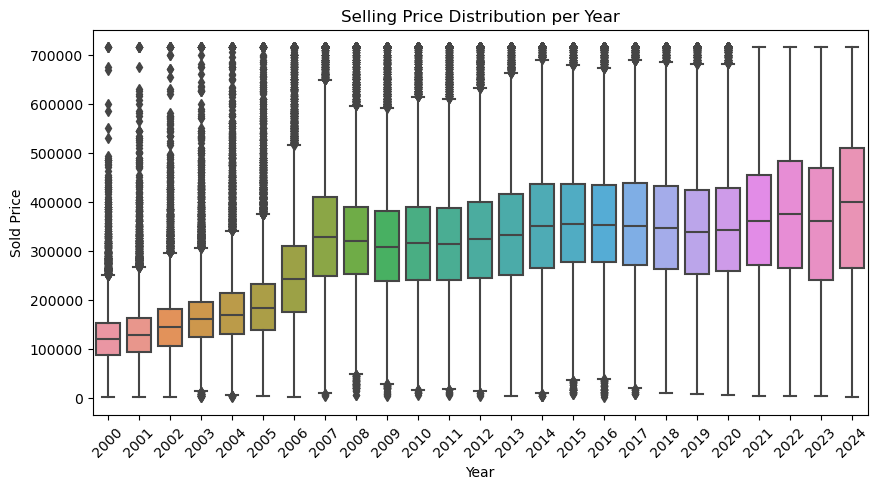

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "SoldData_RealEstate_Edmonton_3960_cleaned_cleaned.csv"  # Update with actual path
df = pd.read_csv(file_path)

# Convert date columns to datetime
df['Sold Date'] = pd.to_datetime(df['Sold Date'])
df['Year'] = df['Sold Date'].dt.year
df['Month'] = df['Sold Date'].dt.month

# Selling Price per Year
plt.figure(figsize=(10, 5))
sns.boxplot(x='Year', y='Sold Price', data=df)
plt.title("Selling Price Distribution per Year")
plt.xticks(rotation=45)
plt.show()



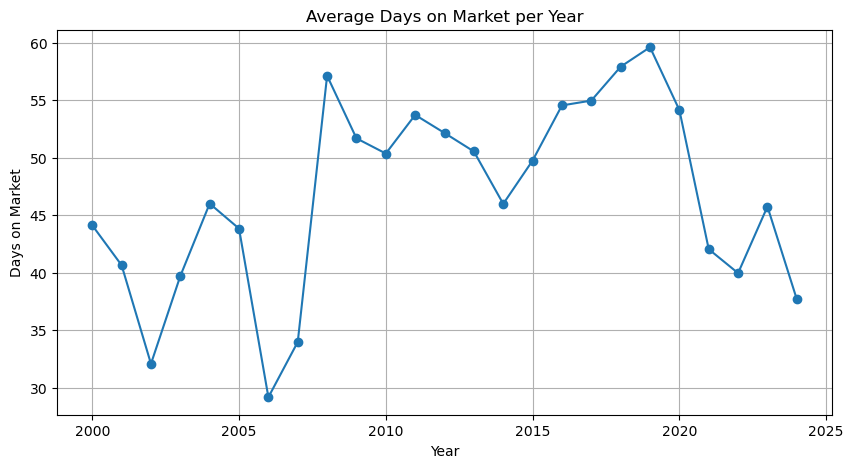

In [3]:
# Average Days on Market per Year
avg_dom = df.groupby('Year')['DOM'].mean()
plt.figure(figsize=(10, 5))
plt.plot(avg_dom, marker='o', linestyle='-')
plt.title("Average Days on Market per Year")
plt.xlabel("Year")
plt.ylabel("Days on Market")
plt.grid()
plt.show()

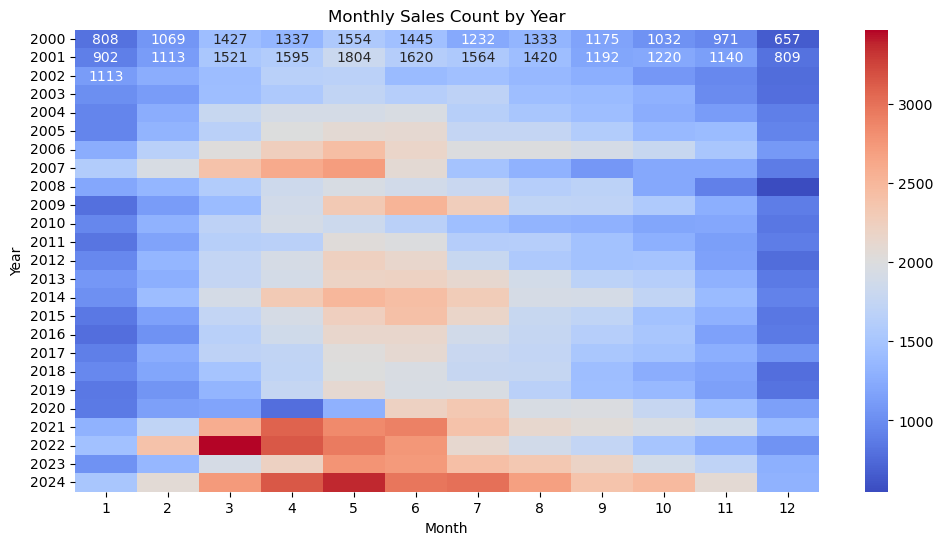

In [4]:
# Monthly Sales Count by Year
sales_count = df.groupby(['Year', 'Month']).size().unstack()
plt.figure(figsize=(12, 6))
sns.heatmap(sales_count, cmap="coolwarm", annot=True, fmt=".0f")
plt.title("Monthly Sales Count by Year")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

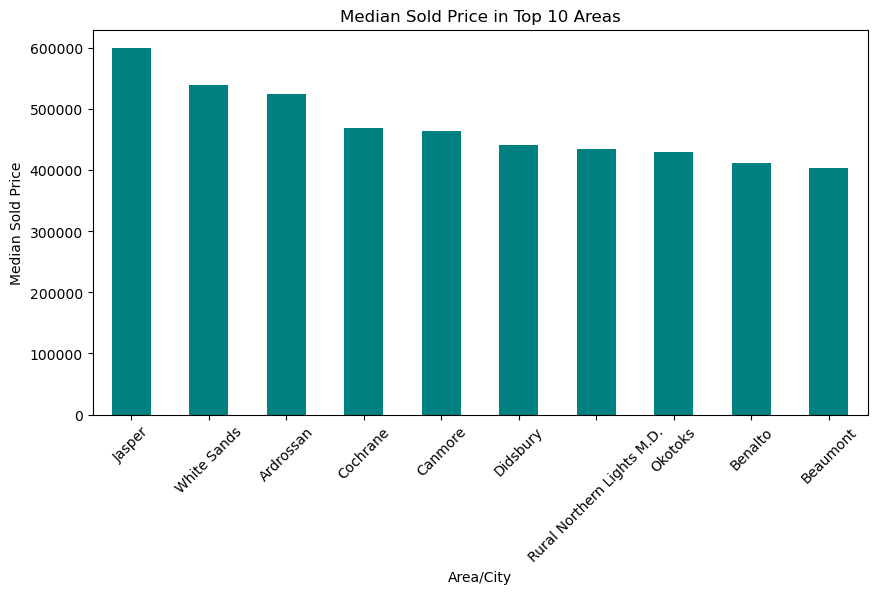

In [5]:
# Price Statistics by Top 10 Areas
top_areas = df.groupby('Area/City')['Sold Price'].median().nlargest(10)
plt.figure(figsize=(10, 5))
top_areas.plot(kind='bar', color='teal')
plt.title("Median Sold Price in Top 10 Areas")
plt.ylabel("Median Sold Price")
plt.xticks(rotation=45)
plt.show()

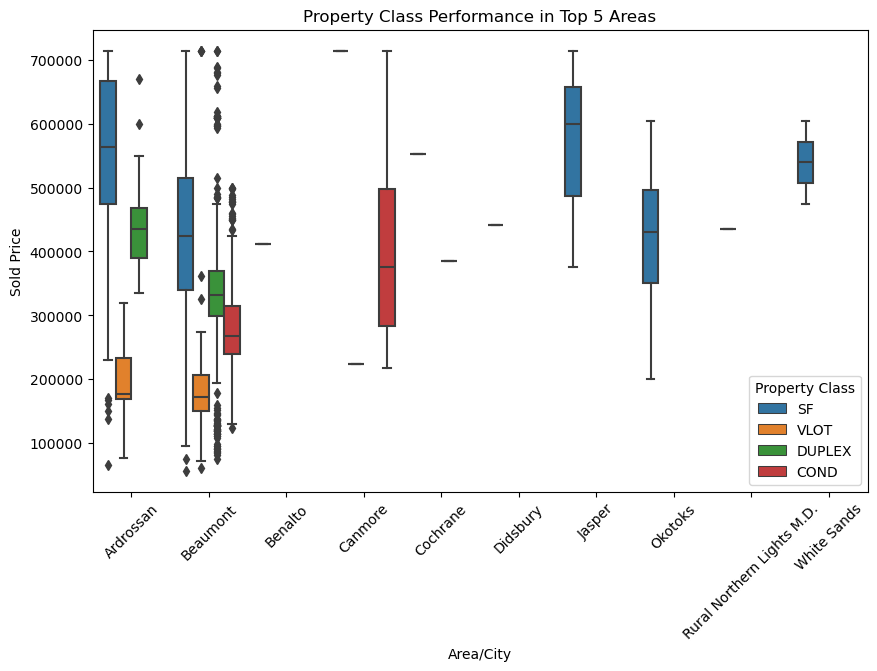

In [6]:
# Property Class Performance in Top 5 Areas
top_5_areas = top_areas.index.tolist()
df_top_areas = df[df['Area/City'].isin(top_5_areas)]
plt.figure(figsize=(10, 6))
sns.boxplot(x='Area/City', y='Sold Price', hue='Prop Class', data=df_top_areas)
plt.title("Property Class Performance in Top 5 Areas")
plt.xticks(rotation=45)
plt.legend(title="Property Class")
plt.show()

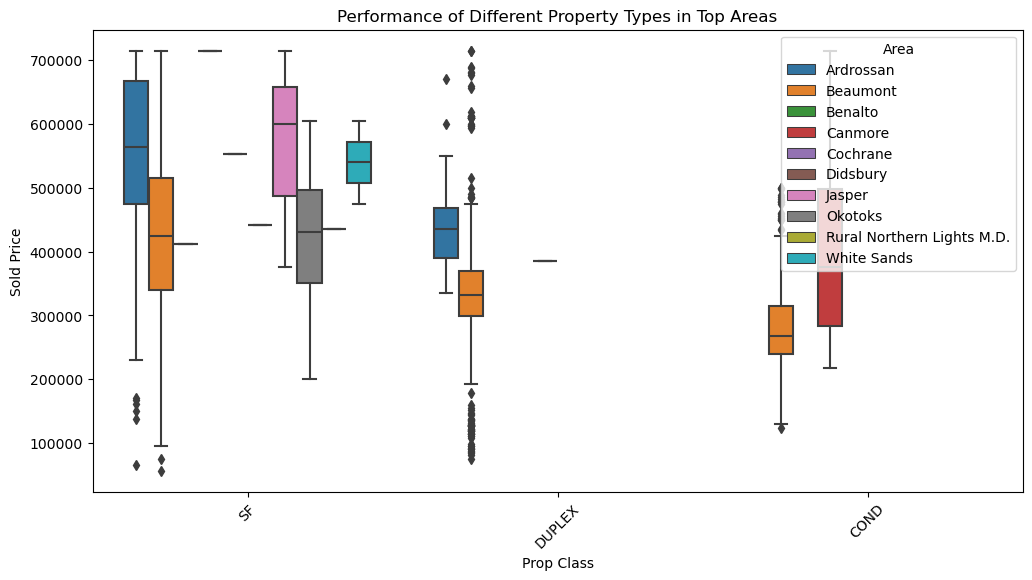

In [8]:

# Performance of SF, COND, and Duplex in Top Areas
property_types = ['SF', 'COND', 'DUPLEX']
df_filtered = df[df['Prop Class'].isin(property_types)]
plt.figure(figsize=(12, 6))
sns.boxplot(x='Prop Class', y='Sold Price', hue='Area/City', data=df_filtered[df_filtered['Area/City'].isin(top_5_areas)])
plt.title("Performance of Different Property Types in Top Areas")
plt.xticks(rotation=45)
plt.legend(title="Area")
plt.show()

